In [1]:
import os
import pandas as pd
import gensim
import numpy as np
from gensim.models.fasttext import FastText
from gensim.models import KeyedVectors

os.chdir('../../')

/Users/Taras_Ustyianovych/workspace/python-envs/climate-discourse-changepoints-venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
# Define constants with vector sizes
WORD_VECTOR_SIZE = 300
DOCUMENT_VECTOR_SIZE = 300

In [53]:
df = pd.read_parquet('data/processed/posts_reactions_df.parquet')
full_text_df = pd.read_parquet('data/processed/main_backup/all_collected_text_data_processed.parquet')

corpus = full_text_df['lemmatized_text_filtered'].to_list()

In [54]:
len(corpus)

5730

In [55]:
corpus = [item for item in corpus if len(item) > 0]

In [56]:
len(corpus)

5730

In [57]:
fasttext_model = FastText.load("models/fasttext-models/fast-text-custom-model-full-climate-text")

#### Load the BERTopic model (trained in eda.ipynb with the FastText model)

In [9]:
from bertopic import BERTopic
import json
bertopic_model = BERTopic.load('models/bertopic-models/bertopic-fasttext64-custom-embeddings-all-data/')
bertopic_data = pd.read_parquet('results/topic-modeling-results/all-data-feb-2025-bertopic-topics-on-reactions-corpus-merged.parquet')

/Users/Taras_Ustyianovych/workspace/python-envs/climate-discourse-changepoints-venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-26 17:34:42,952 - BERTopic - WARNING: You are loading a BERTopic model without explicitly defining an embedding model. If you want to also load in an embedding model, make sure to use `BERTopic.load(my_model, embedding_model=my_embedding_model)`.


In [10]:
topic_list_df = pd.DataFrame(bertopic_model.topics_, columns = ['Topic'])
topic_info_df = pd.merge(topic_list_df, bertopic_data[['Topic', 'Primary Topic', 'Secondary Topic']], on='Topic', how='left')

In [11]:
primary_topic_factor, primary_topic_mapping = topic_info_df['Primary Topic'].factorize()
secondary_topic_factor, secondary_topic_mapping = topic_info_df['Secondary Topic'].factorize()

In [17]:
channel_factor, mapping = df['channel_name'].factorize()

In [18]:
channel_factor

array([0, 0, 0, ..., 6, 6, 6])

In [19]:
len(channel_factor)

4687

In [20]:
df['lemmatized_text_filtered_word_count'] = df['lemmatized_text_filtered'].apply(lambda x: len(x.split()))
full_text_df['lemmatized_text_filtered_word_count'] = full_text_df['lemmatized_text_filtered'].apply(lambda x: len(x.split()))

### Vectorization method #1 - Averaging of word embeddings

In [21]:
# Tokenize and preprocess the text data
def preprocess_text(text):
    return text.lower().split()

# Tokenize and preprocess the training data
tokenized_corpus = [preprocess_text(text) for text in corpus]

In [22]:
tokenized_corpus[0]

['південнокорейський',
 'пусан',
 'завершитися',
 'переговори',
 'представник',
 '170',
 'країна',
 'світ',
 'укладання',
 'договір',
 'боротьба',
 'пластиковий',
 'забруднення',
 'угода',
 'вдатися',
 'досягти',
 'вирішити',
 'продовжити',
 'переговори',
 'наступний',
 'рок']

In [23]:
len(fasttext_model.wv[tokenized_corpus[0][0]])

64

In [24]:
len(tokenized_corpus)

5731

In [25]:
# Create document vectors using fastText model
docVec = []

for i in range(len(tokenized_corpus)):
    # print(i)
    wordVectors = fasttext_model.wv[tokenized_corpus[i]]
    docVecEntity = np.add(0, wordVectors.sum(axis=0))
    docVecResult = np.divide(docVecEntity, len(tokenized_corpus[i]))

    docVec.append(docVecResult)

In [26]:
len(docVec[0])

64

In [27]:
len(docVec)

5731

### Perform PCA and t-SNE (word embedding size = 300)

In [28]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [29]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(docVec)

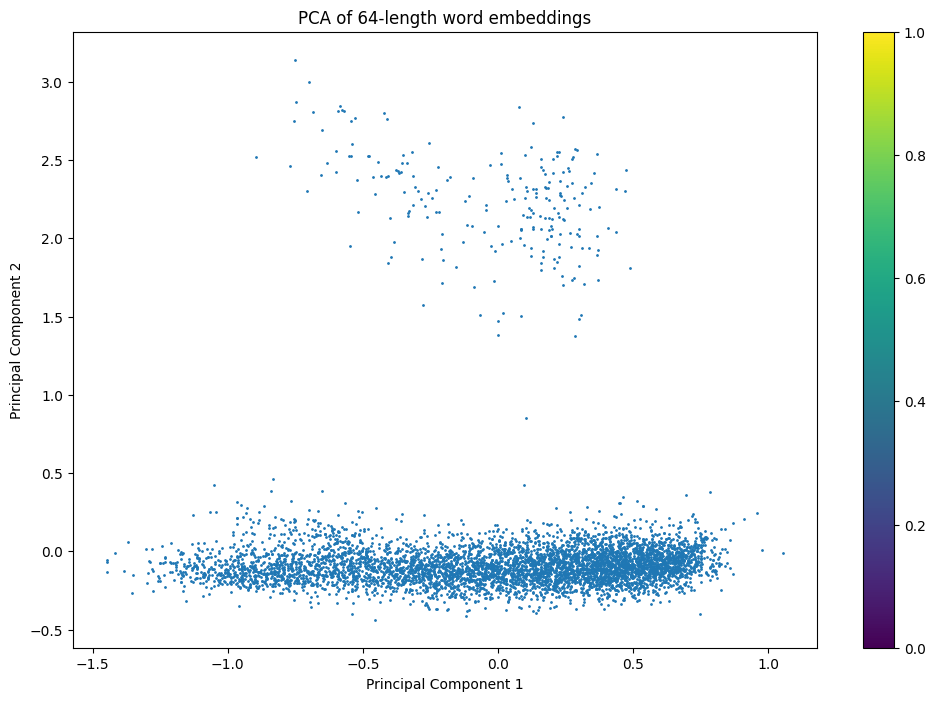

In [30]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)
plt.colorbar(scatter)
plt.title('PCA of 64-length word embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [31]:
np.array(docVec).shape

(5731, 64)

In [41]:
docVec[0]

array([-0.11398246, -0.05407755, -0.0395888 ,  0.00432219,  0.09868572,
       -0.38721204,  0.04792277,  0.19804719,  0.23653662, -0.0886881 ,
        0.2752028 , -0.2738605 ,  0.43605432,  0.24411353, -0.01377159,
       -0.11474415,  0.01766744, -0.15628254, -0.19578382, -0.35249546,
       -0.3535441 ,  0.22104338, -0.0242388 , -0.14985393, -0.16753635,
        0.43063563, -0.0205884 , -0.07415625,  0.2972313 , -0.28259853,
       -0.27661788, -0.14643809, -0.25865674,  0.24178264, -0.0292215 ,
        0.30949506, -0.17867744, -0.3070066 , -0.17107993, -0.07682959,
        0.24180786,  0.2639441 , -0.17880842,  0.18009952,  0.5124175 ,
        0.06769498,  0.18006596,  0.23946501, -0.06500625,  0.21600746,
       -0.08354735,  0.11264652,  0.2463557 ,  0.5462702 , -0.5315711 ,
       -0.03218952, -0.35798806,  0.02337374, -0.01970946, -0.13412309,
       -0.2919694 ,  0.21267153, -0.20406042, -0.44901118], dtype=float32)

In [32]:
docVec[0][:2]

array([-0.25123638, -0.09699281], dtype=float32)

In [33]:
len(docVec)

5731

In [35]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(np.array(docVec))

In [36]:
tsne.kl_divergence_

1.634352207183838

### Perform PCA and t-SNE (word embedding size = 64)

In [37]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

In [38]:
# Apply PCA for initial dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(docVec)

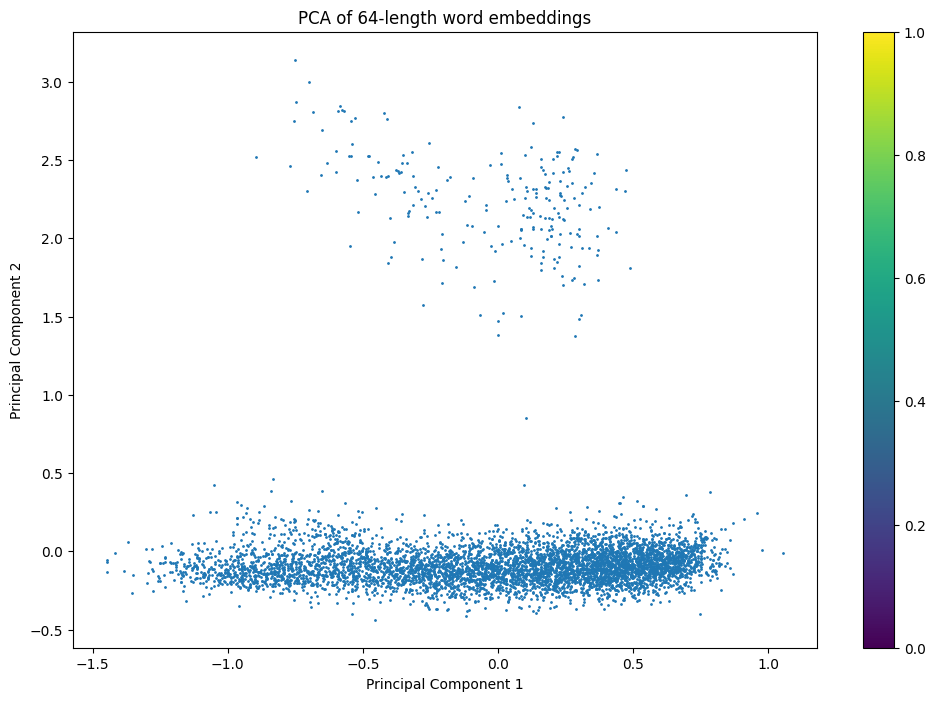

In [39]:
# Plotting with Matplotlib
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_result[:, 0], pca_result[:, 1], cmap='tab10', s=1)
plt.colorbar(scatter)
plt.title('PCA of 64-length word embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

In [40]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=2500, random_state=42)
tsne_result = tsne.fit_transform(np.array(docVec))
print(tsne.kl_divergence_)

1.5954203605651855


### Hyperparameter optimization for embedding size 64 (full text)

In [44]:
import matplotlib.pyplot as plt
import plotly.express as px

import numpy as np
from sklearn.manifold import TSNE
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args

# Sample data - replace this with your actual data
# For example, np.array(docVec) if you have docVec defined

# Define the space of hyperparameters to search
space  = [Integer(5, 80, name='perplexity'),  # Perplexity range
          Integer(300, 8000, name='n_iter')]  # Number of iterations range

# Objective function to minimize
@use_named_args(space)
def objective(**params):
    tsne = TSNE(n_components=2, random_state=42, **params)
    X_tsne = tsne.fit_transform(np.array(docVec))
    return tsne.kl_divergence_

# Perform Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# Best hyperparameters and corresponding KL Divergence
print("Best parameters: {}".format(res_gp.x))
print("Best KL Divergence: {:.5f}".format(res_gp.fun))

Best parameters: [80, 8000]
Best KL Divergence: 1.41545


In [45]:
res_gp.func_vals

array([1.50978589, 1.44417453, 1.50547183, 1.68755639, 1.60311866,
       1.45666218, 1.57612228, 1.58035421, 1.57665539, 1.62186575,
       1.41544604, 1.41708946, 1.42397654, 1.41967535, 1.41591668,
       1.99043369, 1.61226809, 1.42228484, 1.41805935, 1.41635108,
       1.41564584, 1.46809793, 1.41744471, 1.41868925, 1.42318797,
       1.42070878, 1.41668248, 1.41555107, 1.41613007, 1.4157455 ,
       1.44551623, 1.51523578, 1.43808794, 3.20360088, 1.60645509,
       1.43597507, 1.52130556, 1.54684639, 1.56955826, 1.44819462,
       1.69751382, 1.58616638, 1.53715765, 1.52952099, 1.46958721,
       1.4212389 , 1.53750849, 1.41774595, 1.46038222, 1.42016208])

In [46]:
res_gp.x_iters

[[49, 6801],
 [69, 6824],
 [52, 3260],
 [27, 737],
 [25, 3978],
 [66, 3996],
 [34, 6738],
 [30, 5291],
 [33, 7670],
 [16, 7000],
 [80, 8000],
 [80, 5690],
 [80, 2054],
 [80, 3792],
 [80, 7027],
 [80, 300],
 [5, 1944],
 [80, 2634],
 [80, 4708],
 [80, 6430],
 [80, 7549],
 [64, 2163],
 [80, 5207],
 [80, 4244],
 [80, 2317],
 [80, 3276],
 [80, 6075],
 [80, 7792],
 [80, 6744],
 [80, 7296],
 [69, 5489],
 [5, 8000],
 [71, 8000],
 [6, 320],
 [29, 1956],
 [80, 1039],
 [55, 975],
 [5, 4398],
 [5, 3076],
 [80, 728],
 [5, 1197],
 [5, 2532],
 [46, 4692],
 [5, 5890],
 [61, 6120],
 [80, 2971],
 [5, 5138],
 [80, 4958],
 [66, 2733],
 [80, 3546]]

In [47]:
res_gp

          fun: 1.4154460430145264
            x: [80, 8000]
    func_vals: [ 1.510e+00  1.444e+00 ...  1.460e+00  1.420e+00]
      x_iters: [[49, 6801], [69, 6824], [52, 3260], [27, 737], [25, 3978], [66, 3996], [34, 6738], [30, 5291], [33, 7670], [16, 7000], [80, 8000], [80, 5690], [80, 2054], [80, 3792], [80, 7027], [80, 300], [5, 1944], [80, 2634], [80, 4708], [80, 6430], [80, 7549], [64, 2163], [80, 5207], [80, 4244], [80, 2317], [80, 3276], [80, 6075], [80, 7792], [80, 6744], [80, 7296], [69, 5489], [5, 8000], [71, 8000], [6, 320], [29, 1956], [80, 1039], [55, 975], [5, 4398], [5, 3076], [80, 728], [5, 1197], [5, 2532], [46, 4692], [5, 5890], [61, 6120], [80, 2971], [5, 5138], [80, 4958], [66, 2733], [80, 3546]]
       models: [GaussianProcessRegressor(kernel=1**2 * Matern(length_scale=[1, 1], nu=2.5) + WhiteKernel(noise_level=1),
                                        n_restarts_optimizer=2, noise='gaussian',
                                        normalize_y=True, random_state

### Split by BERTopic Primary Topic Groups

In [58]:
primary_topic_factor
# secondary_topic_factor

array([0, 1, 1, ..., 4, 4, 4])

In [59]:
primary_topic_factor, primary_topic_mapping = full_text_df['Primary Topic'].factorize()

In [61]:
legeld_labels = [primary_topic_mapping[i] for i in primary_topic_factor]

In [62]:
primary_topic_mapping

Index(['Geopolitical & War Dynamics',
       'War-Related Environmental and Resource Impact', 'Miscellaneous',
       'Environmental and Climate Issues', 'Energy and Resources'],
      dtype='object')

In [63]:
# Apply t-SNE
tsne = TSNE(n_components=2, perplexity=80, n_iter=8000, random_state=42)
tsne_result = tsne.fit_transform(np.array(docVec))
print(tsne.kl_divergence_)

1.4154460430145264


In [64]:
for index, i in enumerate(primary_topic_mapping):
    print(index, i)

0 Geopolitical & War Dynamics
1 War-Related Environmental and Resource Impact
2 Miscellaneous
3 Environmental and Climate Issues
4 Energy and Resources


In [65]:
primary_topic_mapping_dict = {
    0: 'Geopolitical & War Dynamics',
    1: 'War-Related Environmental and Resource Impact',
    2: 'Miscellaneous',
    3: 'Environmental and Climate Issues',
    4: 'Energy and Resources'
}

ValueError: 'c' argument has 5730 elements, which is inconsistent with 'x' and 'y' with size 5731.

<Figure size 1920x1440 with 0 Axes>

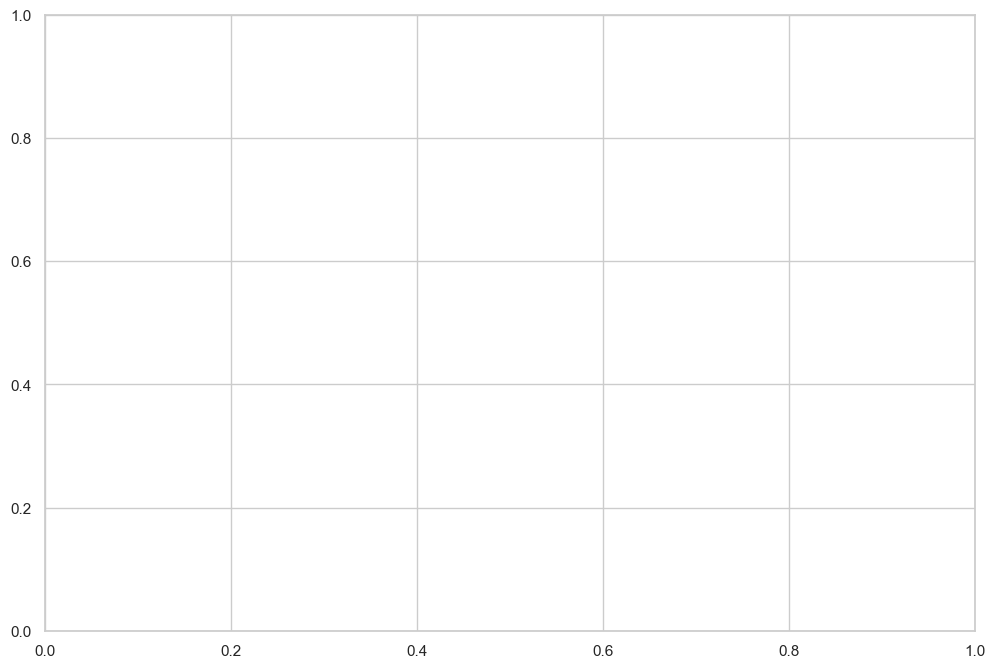

In [66]:
# Set the Seaborn style and Matplotlib figure resolution
sns.set(style="whitegrid")
plt.figure(dpi=300)

# Plot the result
plt.figure(figsize=(12, 8))
scatter = plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=primary_topic_factor, cmap='tab10', s=1)
# plt.legend(*scatter.legend_elements(), title="Digits")
# Generate legend elements
legend_elements, _ = scatter.legend_elements()
# Create legend labels from the mapping
legend_labels = [primary_topic_mapping_dict[i] for i in np.unique(primary_topic_factor)]

# Create the legend with the mapped labels
plt.legend(handles=legend_elements, labels=legend_labels, title="Primary Topics")
plt.title('t-SNE plot of Primary Topic Groups')

# Save the figure with high resolution
plt.tight_layout()
plt.savefig("figures/t-SNE-primary-groups.png", dpi=300)

plt.show()